In [3]:
#Importing required libraries
import pandas as pd  #pandas for importing files and rearranging the data
import numpy as np
import seaborn as sb
from scipy import sparse #scipy for math functions
from sklearn.metrics.pairwise import cosine_similarity #sklearn for cosine similarity
import sys
import pickle
import matplotlib.pyplot as plt
import math
import seaborn as sns
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
dataset = pd.read_csv('data/dataset.csv')

if not os.path.isfile('train/train.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    dataset.iloc[:int(dataset.shape[0]*0.80)].to_csv("train/train.csv", index=False)

if not os.path.isfile('test/test.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    dataset.iloc[int(dataset.shape[0]*0.80):].to_csv("test/test.csv", index=False)

train = pd.read_csv("train/train.csv")
test = pd.read_csv("test/test.csv")

In [9]:
dataPD=train
dataPD.describe()

userID        itemID           age           sex          city  \
count  16497.000000  16497.000000  16497.000000  16497.000000  16497.000000   
mean    1023.287810   2774.155847     28.098745      1.509426     13.284112   
std      667.823146   1691.477297     20.923844      0.499926      6.581464   
min       15.000000      1.000000      0.000000      1.000000      1.000000   
25%      373.000000    224.000000     22.000000      1.000000     10.000000   
50%      959.000000   3687.000000     28.000000      2.000000     10.000000   
75%     1455.000000   4005.000000     32.000000      2.000000     20.000000   
max     2445.000000   4381.000000    900.000000      2.000000     22.000000   

            country      director  movieCountry  movieLanguage     movieYear  \
count  16497.000000  16497.000000  16497.000000   16497.000000  16497.000000   
mean       2.225677    409.345396     33.943808       9.607868   2003.938110   
std        0.720811    239.262197      8.002769       2.966454     10.161952   
min        1.000000      0.000000      1.000000       0.000000   1902.000000   
25%        2.000000    195.000000     37.000000       9.000000   2002.000000   
50%        2.000000    399.000000     37.000000       9.000000   2008.000000   
75%        3.000000    624.000000     37.000000       9.000000   2010.000000   
max        4.000000    815.000000     39.000000      28.000000   2012.000000   

       ...       weather        social        endEmo   dominantEmo  \
count  ...  16497.000000  16497.000000  16497.000000  16497.000000   
mean   ...      2.698369      1.985997      4.003940      4.303631   
std    ...      1.821128      1.594193      2.400755      2.291766   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      1.000000      1.000000      2.000000      2.000000   
50%    ...      2.000000      1.000000      2.000000      4.000000   
75%    ...      5.000000      2.000000      7.000000      7.000000   
max    ...      5.000000      7.000000      7.000000      7.000000   

               mood      physical      decition   interaction         genre  \
count  16497.000000  16497.000000  16497.000000  16497.000000  16497.000000   
mean       1.550767      1.122992      1.265685      1.207068      5.578348   
std        0.626743      0.357089      0.459865      0.425219      3.899431   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      1.000000      1.000000      1.000000      1.000000   
50%        1.000000      1.000000      1.000000      1.000000      7.000000   
75%        2.000000      1.000000      2.000000      1.000000      8.000000   
max        3.000000      2.000000      2.000000      2.000000     19.000000   

             rating  
count  1.649700e+04  
mean   1.176919e+05  
std    3.220919e+06  
min    0.000000e+00  
25%    3.000000e+00  
50%    4.000000e+00  
75%    5.000000e+00  
max    1.600000e+08  

[8 rows x 30 columns]

In [6]:
def showDataStats(inPD):
    """ Show selected statistics on given item ratings dataframe
    """
    # Get some numbers
    print("Rows: {0}".format(inPD.size))
    print("Distinct item: {0}".format(inPD['itemID'].unique().size))
    print("Distinct Users: {0}".format(inPD['userID'].unique().size))
  
    # Plot some histograms to get a feeling for the data
    numRatingsPerUserPD = inPD.groupby('userID')['itemID'].count()
    n, bins, patches = plt.hist(numRatingsPerUserPD.as_matrix(), 100, log=True, facecolor='blue', alpha=0.75)
    plt.xlabel('#Ratings')
    plt.ylabel('#Users')
    plt.title('#ratings per user')
    plt.grid(True)
    plt.show()

    numRatingsPerMoviePD = inPD.groupby('itemID')['userID'].count()
    n, bins, patches = plt.hist(numRatingsPerMoviePD.as_matrix(), 100, log=True, facecolor='blue', alpha=0.75)
    plt.xlabel('#Ratings')
    plt.ylabel('#item')
    plt.title('#ratings per item')
    plt.grid(True)
    plt.show()
showDataStats(dataPD)

Rows: 494910
Distinct item: 1231
Distinct Users: 798


AttributeError: 'Series' object has no attribute 'as_matrix'

In [7]:
filteredDataPD = dataPD

In [10]:
# Filter out the bottom 95% of the movies
numRatingsPerMoviePD = filteredDataPD.groupby('itemID')['userID'].count()
filterOutMoviesPD = numRatingsPerMoviePD[(numRatingsPerMoviePD <= np.percentile(numRatingsPerMoviePD, 95))]
filteredDataPD = filteredDataPD[~filteredDataPD['itemID'].isin(filterOutMoviesPD.index)]

In [11]:
distinctUsers = filteredDataPD['userID'].unique()
filterUsersPD = pd.DataFrame(distinctUsers, columns=['userID']).sample(frac=0.1)
filteredDataPD = filteredDataPD[filteredDataPD['userID'].isin(filterUsersPD['userID'])]

In [12]:
numRatingsPerUserPD = filteredDataPD.groupby('userID')['itemID'].count()
filterOutUsersPD = numRatingsPerUserPD[(numRatingsPerUserPD <= np.percentile(numRatingsPerUserPD, 10))
                              | (numRatingsPerUserPD >= np.percentile(numRatingsPerUserPD, 90))]
filteredDataPD = filteredDataPD[~filteredDataPD['userID'].isin(filterOutUsersPD.index)]

Rows: 5070
Distinct item: 53
Distinct Users: 29


C:\Users\Vahidi\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


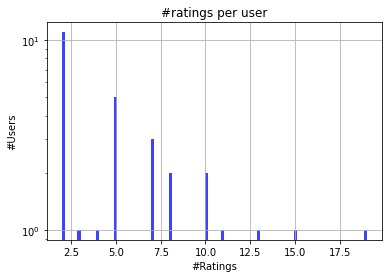

C:\Users\Vahidi\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


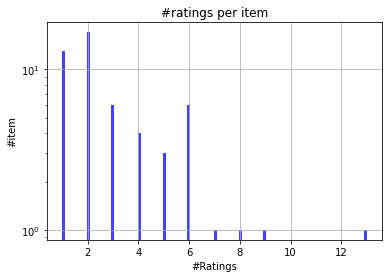

In [28]:
showDataStats(filteredDataPD)